# WINGS GPU Benchmarking

This notebook benchmarks GPU vs CPU performance and helps identify optimal backend selection.

**Tests covered:**
- CPU baseline performance
- GPU (Qiskit Aer) performance
- cuStateVec performance
- Multi-GPU scaling (if available)
- Crossover point analysis
- Gradient computation comparison

In [1]:
# ============================================================================
# FRESH START - Run this FIRST after kernel restart
# ============================================================================
import sys
from pathlib import Path

# Clean up sys.path - remove any gaussian_state_optimizer paths
sys.path = [p for p in sys.path if 'gaussian_state_optimizer' not in p and 'optimization' not in p]

# Add the correct path
src_path = Path.cwd() / 'optimization-files' / 'src'
sys.path.insert(0, str(src_path))

print("sys.path (first 3):")
for p in sys.path[:3]:
    print(f"  {p}")

# Now verify the package exists at that location
init_file = src_path / 'gaussian_state_optimizer' / '__init__.py'
print(f"\n__init__.py exists: {init_file.exists()}")

if init_file.exists():
    print(f"✓ Package found at: {src_path / 'gaussian_state_optimizer'}")
else:
    print(f"✗ Package NOT found. Check your directory structure.")
    print(f"  Looking for: {init_file}")

sys.path (first 3):
  /home/jmc03846/WINGS_debug/optimization-files/src
  /home/jmc03846/WINGS_debug
  

__init__.py exists: True
✓ Package found at: /home/jmc03846/WINGS_debug/optimization-files/src/gaussian_state_optimizer


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
from collections import defaultdict

# Import WINGS
from gaussian_state_optimizer import (
    GaussianOptimizer,
    OptimizerConfig,
    get_backend_info,
    print_backend_info,
)

print_backend_info()

backend_info = get_backend_info()
HAS_GPU = backend_info['gpu_aer']
HAS_CUSTATEVEC = backend_info['custatevec']

print(f"\nBenchmarking available backends:")
print(f"  CPU: ✓")
print(f"  GPU (Aer): {'✓' if HAS_GPU else '✗'}")
print(f"  cuStateVec: {'✓' if HAS_CUSTATEVEC else '✗'}")

Detected HPC scratch directory: /scratch/jmc03846
Created/verified directory: /home/jmc03846/lib
Created/verified directory: /scratch/jmc03846/coefficient_cache
Created/verified directory: /scratch/jmc03846/simulation_output
Created/verified directory: /scratch/jmc03846/simulation_data
Created/verified directory: /scratch/jmc03846/optimization_checkpoints
Created/verified directory: /scratch/jmc03846/optimization_campaigns
Gaussian State Optimizer - Backend Information
  CPU (Qiskit Statevector): ✓ Available
  GPU (Qiskit Aer):         ✓ Available
  cuStateVec:               ✓ Available

Benchmarking available backends:
  CPU: ✓
  GPU (Aer): ✓
  cuStateVec: ✓


## 1. Helper Functions

In [3]:
def benchmark_single_eval(optimizer, params, n_trials=10, warmup=3):
    """Benchmark single statevector evaluation."""
    # Warmup
    for _ in range(warmup):
        _ = optimizer.get_statevector(params)
    
    # Timed runs
    times = []
    for _ in range(n_trials):
        start = time.perf_counter()
        _ = optimizer.get_statevector(params)
        times.append(time.perf_counter() - start)
    
    return np.mean(times), np.std(times)


def benchmark_fidelity(optimizer, params, n_trials=10, warmup=3):
    """Benchmark fidelity computation."""
    # Warmup
    for _ in range(warmup):
        _ = optimizer.compute_fidelity(params=params)
    
    # Timed runs
    times = []
    for _ in range(n_trials):
        start = time.perf_counter()
        _ = optimizer.compute_fidelity(params=params)
        times.append(time.perf_counter() - start)
    
    return np.mean(times), np.std(times)


def benchmark_gradient(optimizer, params, n_trials=3, warmup=1):
    """Benchmark gradient computation."""
    # Warmup
    for _ in range(warmup):
        _ = optimizer.compute_gradient(params)
    
    # Timed runs
    times = []
    for _ in range(n_trials):
        start = time.perf_counter()
        _ = optimizer.compute_gradient(params)
        times.append(time.perf_counter() - start)
    
    return np.mean(times), np.std(times)


def cleanup_gpu():
    """Clean up GPU memory."""
    gc.collect()
    if HAS_CUSTATEVEC:
        try:
            import cupy as cp
            cp.get_default_memory_pool().free_all_blocks()
        except:
            pass

## 2. Single Evaluation Benchmark

In [4]:
# Test configuration
N_QUBITS = 10
SIGMA = 0.5

print(f"Benchmarking with {N_QUBITS} qubits ({2**N_QUBITS} states, {N_QUBITS**2} parameters)")

# Generate test parameters
np.random.seed(42)
test_params = np.random.randn(N_QUBITS**2) * 0.1

results = {}

Benchmarking with 10 qubits (1024 states, 100 parameters)


In [5]:
# CPU Benchmark
print("\n" + "="*60)
print("CPU BENCHMARK")
print("="*60)

config_cpu = OptimizerConfig(
    n_qubits=N_QUBITS,
    sigma=SIGMA,
    verbose=False,
    use_gpu=False,
    use_custatevec=False,
)

opt_cpu = GaussianOptimizer(config_cpu)

# Benchmark
mean_time, std_time = benchmark_single_eval(opt_cpu, test_params)
results['cpu'] = {'single_eval': mean_time, 'single_eval_std': std_time}

print(f"  Single evaluation: {mean_time*1000:.2f} ± {std_time*1000:.2f} ms")

# Fidelity
mean_fid, std_fid = benchmark_fidelity(opt_cpu, test_params)
results['cpu']['fidelity'] = mean_fid
print(f"  Fidelity computation: {mean_fid*1000:.2f} ± {std_fid*1000:.2f} ms")

# Gradient
print("  Computing gradient (this may take a while)...")
mean_grad, std_grad = benchmark_gradient(opt_cpu, test_params, n_trials=2)
results['cpu']['gradient'] = mean_grad
print(f"  Gradient computation: {mean_grad:.2f} ± {std_grad:.2f} s")


CPU BENCHMARK
  Single evaluation: 7.06 ± 0.11 ms
  Fidelity computation: 7.05 ± 0.10 ms
  Computing gradient (this may take a while)...
  Gradient computation: 3.44 ± 0.12 s


In [6]:
# GPU (Aer) Benchmark
if HAS_GPU:
    print("\n" + "="*60)
    print("GPU (Qiskit Aer) BENCHMARK")
    print("="*60)
    
    config_gpu = OptimizerConfig(
        n_qubits=N_QUBITS,
        sigma=SIGMA,
        verbose=False,
        use_gpu=True,
        use_custatevec=False,
        gpu_precision='double',
    )
    
    opt_gpu = GaussianOptimizer(config_gpu)
    
    if opt_gpu._gpu_evaluator and opt_gpu._gpu_evaluator.gpu_available:
        # Benchmark
        mean_time, std_time = benchmark_single_eval(opt_gpu, test_params)
        results['gpu_aer'] = {'single_eval': mean_time, 'single_eval_std': std_time}
        speedup = results['cpu']['single_eval'] / mean_time
        print(f"  Single evaluation: {mean_time*1000:.2f} ± {std_time*1000:.2f} ms ({speedup:.1f}x speedup)")
        
        # Fidelity
        mean_fid, std_fid = benchmark_fidelity(opt_gpu, test_params)
        results['gpu_aer']['fidelity'] = mean_fid
        speedup_fid = results['cpu']['fidelity'] / mean_fid
        print(f"  Fidelity computation: {mean_fid*1000:.2f} ± {std_fid*1000:.2f} ms ({speedup_fid:.1f}x speedup)")
        
        # Gradient
        print("  Computing gradient...")
        mean_grad, std_grad = benchmark_gradient(opt_gpu, test_params, n_trials=2)
        results['gpu_aer']['gradient'] = mean_grad
        speedup_grad = results['cpu']['gradient'] / mean_grad
        print(f"  Gradient computation: {mean_grad:.2f} ± {std_grad:.2f} s ({speedup_grad:.1f}x speedup)")
    else:
        print("  GPU not actually available, skipping...")
    
    cleanup_gpu()
else:
    print("\nGPU (Aer) not available, skipping...")


GPU (Qiskit Aer) BENCHMARK

Initializing GPU acceleration...
  ✓ GPU backend initialized
    Precision: double
    Available devices: ['GPU']
  GPU acceleration enabled
  Single evaluation: 4.12 ± 0.07 ms (1.7x speedup)
  Fidelity computation: 4.13 ± 0.05 ms (1.7x speedup)
  Computing gradient...
  Gradient computation: 0.81 ± 0.08 s (4.3x speedup)


In [7]:
# cuStateVec Benchmark
if HAS_CUSTATEVEC:
    print("\n" + "="*60)
    print("cuStateVec BENCHMARK")
    print("="*60)
    
    config_cusv = OptimizerConfig(
        n_qubits=N_QUBITS,
        sigma=SIGMA,
        verbose=False,
        use_gpu=False,
        use_custatevec=True,
        gpu_precision='double',
    )
    
    opt_cusv = GaussianOptimizer(config_cusv)
    
    if opt_cusv._custatevec_evaluator is not None:
        # Benchmark
        mean_time, std_time = benchmark_single_eval(opt_cusv, test_params)
        results['custatevec'] = {'single_eval': mean_time, 'single_eval_std': std_time}
        speedup = results['cpu']['single_eval'] / mean_time
        print(f"  Single evaluation: {mean_time*1000:.2f} ± {std_time*1000:.2f} ms ({speedup:.1f}x speedup)")
        
        # Fidelity
        mean_fid, std_fid = benchmark_fidelity(opt_cusv, test_params)
        results['custatevec']['fidelity'] = mean_fid
        speedup_fid = results['cpu']['fidelity'] / mean_fid
        print(f"  Fidelity computation: {mean_fid*1000:.2f} ± {std_fid*1000:.2f} ms ({speedup_fid:.1f}x speedup)")
        
        # Gradient
        print("  Computing gradient...")
        mean_grad, std_grad = benchmark_gradient(opt_cusv, test_params, n_trials=2)
        results['custatevec']['gradient'] = mean_grad
        speedup_grad = results['cpu']['gradient'] / mean_grad
        print(f"  Gradient computation: {mean_grad:.2f} ± {std_grad:.2f} s ({speedup_grad:.1f}x speedup)")
    else:
        print("  cuStateVec evaluator not initialized, skipping...")
    
    cleanup_gpu()
else:
    print("\ncuStateVec not available, skipping...")


cuStateVec BENCHMARK

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4
  Single evaluation: 8.21 ± 0.08 ms (0.9x speedup)
  Fidelity computation: 8.45 ± 0.06 ms (0.8x speedup)
  Computing gradient...
  Gradient computation: 1.68 ± 0.00 s (2.0x speedup)


## 3. Scaling Analysis (Qubit Count)

In [8]:
# Test different qubit counts
QUBIT_RANGE = [6, 8, 10, 12]
if HAS_CUSTATEVEC:
    QUBIT_RANGE.extend([14])  # Larger sizes only with GPU

scaling_results = defaultdict(dict)

print("Scaling analysis across qubit counts...")
print(f"Testing: {QUBIT_RANGE} qubits\n")

Scaling analysis across qubit counts...
Testing: [6, 8, 10, 12, 14] qubits



In [9]:
for n_qubits in QUBIT_RANGE:
    print(f"\n--- {n_qubits} qubits ({2**n_qubits} states) ---")
    
    np.random.seed(42)
    params = np.random.randn(n_qubits**2) * 0.1
    
    # CPU
    config = OptimizerConfig(
        n_qubits=n_qubits, sigma=0.5, verbose=False,
        use_gpu=False, use_custatevec=False,
    )
    opt = GaussianOptimizer(config)
    mean_time, _ = benchmark_single_eval(opt, params, n_trials=5)
    scaling_results['cpu'][n_qubits] = mean_time
    print(f"  CPU: {mean_time*1000:.2f} ms")
    
    # cuStateVec
    if HAS_CUSTATEVEC:
        config = OptimizerConfig(
            n_qubits=n_qubits, sigma=0.5, verbose=False,
            use_gpu=False, use_custatevec=True,
        )
        opt = GaussianOptimizer(config)
        if opt._custatevec_evaluator:
            mean_time, _ = benchmark_single_eval(opt, params, n_trials=5)
            scaling_results['custatevec'][n_qubits] = mean_time
            speedup = scaling_results['cpu'][n_qubits] / mean_time
            print(f"  cuStateVec: {mean_time*1000:.2f} ms ({speedup:.1f}x)")
        cleanup_gpu()

print("\n✓ Scaling analysis complete")


--- 6 qubits (64 states) ---
  CPU: 2.23 ms

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4
  cuStateVec: 2.96 ms (0.8x)

--- 8 qubits (256 states) ---
  CPU: 4.00 ms

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4
  cuStateVec: 5.35 ms (0.7x)

--- 10 qubits (1024 states) ---
  CPU: 7.06 ms

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4
  cuStateVec: 8.29 ms (0.9x)

--- 12 qubits (4096 states) ---
  CPU: 13.77 ms

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4
  cuStateVec: 11.88 ms (1.2x)

--- 14 qubits (16384 states) ---
  CPU: 75.20 ms

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4
  cuStateVec: 15.86 ms (4.7x)

✓ Scaling analysis complete


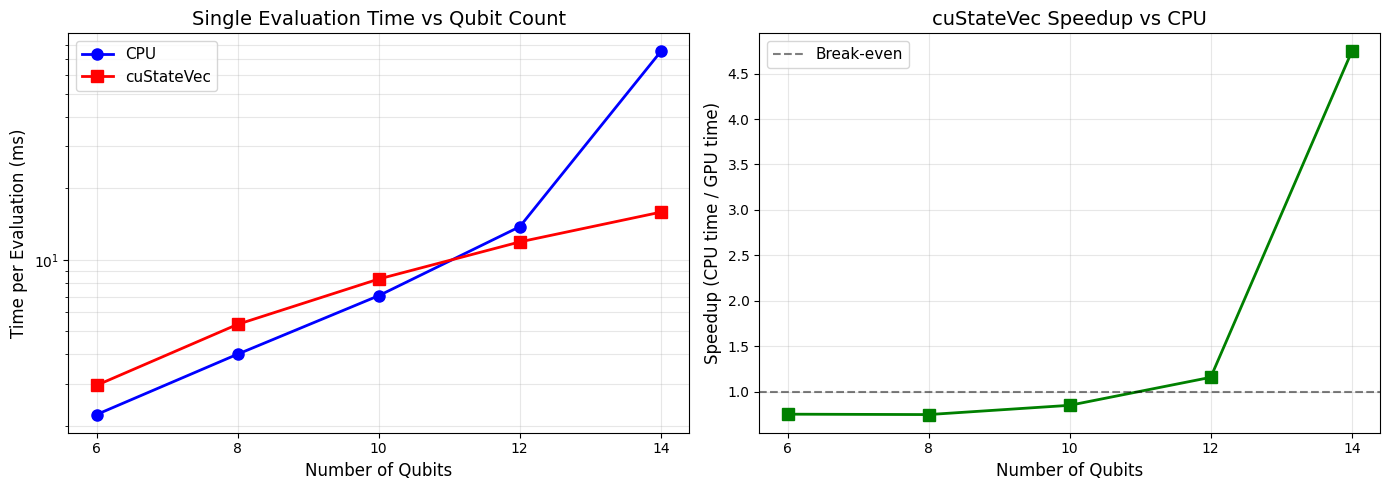

In [10]:
# Plot scaling results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Absolute times
ax = axes[0]
qubits = list(scaling_results['cpu'].keys())
cpu_times = [scaling_results['cpu'][q] * 1000 for q in qubits]
ax.semilogy(qubits, cpu_times, 'bo-', linewidth=2, markersize=8, label='CPU')

if 'custatevec' in scaling_results and scaling_results['custatevec']:
    cusv_qubits = list(scaling_results['custatevec'].keys())
    cusv_times = [scaling_results['custatevec'][q] * 1000 for q in cusv_qubits]
    ax.semilogy(cusv_qubits, cusv_times, 'rs-', linewidth=2, markersize=8, label='cuStateVec')

ax.set_xlabel('Number of Qubits', fontsize=12)
ax.set_ylabel('Time per Evaluation (ms)', fontsize=12)
ax.set_title('Single Evaluation Time vs Qubit Count', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')
ax.set_xticks(qubits)

# Plot 2: Speedup
ax = axes[1]
if 'custatevec' in scaling_results and scaling_results['custatevec']:
    speedups = [scaling_results['cpu'][q] / scaling_results['custatevec'][q] 
                for q in cusv_qubits if q in scaling_results['cpu']]
    ax.plot(cusv_qubits[:len(speedups)], speedups, 'gs-', linewidth=2, markersize=8)
    ax.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Break-even')
    ax.set_xlabel('Number of Qubits', fontsize=12)
    ax.set_ylabel('Speedup (CPU time / GPU time)', fontsize=12)
    ax.set_title('cuStateVec Speedup vs CPU', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(cusv_qubits[:len(speedups)])
    ax.legend(fontsize=11)
else:
    ax.text(0.5, 0.5, 'cuStateVec not available', ha='center', va='center', 
            transform=ax.transAxes, fontsize=14)

plt.tight_layout()
plt.savefig('gpu_scaling.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Batch Evaluation Benchmark

In [11]:
# Test batch evaluation (important for gradient computation)
N_QUBITS_BATCH = 8
BATCH_SIZES = [8, 16, 32, 64, 128]

batch_results = defaultdict(dict)

print(f"Batch evaluation benchmark ({N_QUBITS_BATCH} qubits)")
print(f"Batch sizes: {BATCH_SIZES}\n")

for batch_size in BATCH_SIZES:
    print(f"--- Batch size {batch_size} ---")
    
    np.random.seed(42)
    population = np.random.randn(batch_size, N_QUBITS_BATCH**2) * 0.1
    
    # CPU
    config = OptimizerConfig(
        n_qubits=N_QUBITS_BATCH, sigma=0.5, verbose=False,
        use_gpu=False, use_custatevec=False,
    )
    opt = GaussianOptimizer(config)
    
    start = time.perf_counter()
    _ = opt.evaluate_population(population)
    cpu_time = time.perf_counter() - start
    batch_results['cpu'][batch_size] = cpu_time
    print(f"  CPU: {cpu_time*1000:.1f} ms ({cpu_time/batch_size*1000:.2f} ms/sample)")
    
    # cuStateVec
    if HAS_CUSTATEVEC:
        config = OptimizerConfig(
            n_qubits=N_QUBITS_BATCH, sigma=0.5, verbose=False,
            use_gpu=False, use_custatevec=True,
        )
        opt = GaussianOptimizer(config)
        
        if opt._custatevec_batch_evaluator:
            # Warmup
            _ = opt.evaluate_population(population[:8])
            
            start = time.perf_counter()
            _ = opt.evaluate_population(population)
            cusv_time = time.perf_counter() - start
            batch_results['custatevec'][batch_size] = cusv_time
            speedup = cpu_time / cusv_time
            print(f"  cuStateVec: {cusv_time*1000:.1f} ms ({cusv_time/batch_size*1000:.2f} ms/sample, {speedup:.1f}x)")
        
        cleanup_gpu()

print("\n✓ Batch benchmark complete")

Batch evaluation benchmark (8 qubits)
Batch sizes: [8, 16, 32, 64, 128]

--- Batch size 8 ---
  CPU: 54.5 ms (6.81 ms/sample)

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4
  cuStateVec: 44.7 ms (5.58 ms/sample, 1.2x)
--- Batch size 16 ---
  CPU: 92.6 ms (5.79 ms/sample)

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4
  cuStateVec: 90.5 ms (5.66 ms/sample, 1.0x)
--- Batch size 32 ---
  CPU: 191.2 ms (5.98 ms/sample)

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4
  cuStateVec: 179.0 ms (5.59 ms/sample, 1.1x)
--- Batch size 64 ---
  CPU: 335.5 ms (5.24 ms/sample)

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4
  cuStateVec: 358.7 ms (5.60 ms/sample, 0.9x)
--- Batch size 128 ---
  CPU: 692.0 ms (5.41 ms/sample)

Initializing cu

## 5. Full Optimization Benchmark

In [12]:
from gaussian_state_optimizer.config import OptimizationPipeline

N_QUBITS_OPT = 8
TARGET_FIDELITY = 0.999
MAX_TIME = 60  # seconds

opt_results = {}

print(f"Full optimization benchmark ({N_QUBITS_OPT} qubits, target F={TARGET_FIDELITY})")
print(f"Max time: {MAX_TIME}s per run\n")

Full optimization benchmark (8 qubits, target F=0.999)
Max time: 60s per run



In [13]:
# CPU Optimization
print("="*60)
print("CPU OPTIMIZATION")
print("="*60)

config = OptimizerConfig(
    n_qubits=N_QUBITS_OPT, sigma=0.5, verbose=False,
    use_gpu=False, use_custatevec=False,
)
opt = GaussianOptimizer(config)

pipeline = OptimizationPipeline(
    target_fidelity=TARGET_FIDELITY,
    max_total_time=MAX_TIME,
    use_adam_stage=True,
    adam_max_steps=500,
    verbose=False,
)

start = time.time()
results_cpu = opt.run_optimization(pipeline)
cpu_total_time = time.time() - start

opt_results['cpu'] = {
    'fidelity': results_cpu['fidelity'],
    'time': cpu_total_time,
    'n_evals': results_cpu['n_evaluations'],
}

print(f"  Fidelity: {results_cpu['fidelity']:.10f}")
print(f"  Time: {cpu_total_time:.1f}s")
print(f"  Evaluations: {results_cpu['n_evaluations']}")
cpu_evals_per_sec = results_cpu['n_evaluations'] / cpu_total_time if cpu_total_time > 0 else 0
print(f"  Evals/second: {cpu_evals_per_sec:.1f}")

CPU OPTIMIZATION

Adam Optimization (lr=0.01, max_steps=500)
--------------------------------------------------
  Step     0: F=0.1043760571, |∇|=2.47e-01, lr=0.0100
  Step   100: F=0.9277522778, |∇|=1.09e-01, lr=0.0051
  Step   200: F=0.9635334494, |∇|=5.43e-02, lr=0.0100
  Step   300: F=0.9935667755, |∇|=1.04e-02, lr=0.0075
  Step   400: F=0.9965535991, |∇|=5.56e-03, lr=0.0027

Adam complete: F=0.996791442843 in 257.5s (500 steps)
  Fidelity: 0.9967914428
  Time: 257.5s
  Evaluations: 0
  Evals/second: 0.0


In [14]:
# cuStateVec Optimization
if HAS_CUSTATEVEC:
    print("\n" + "="*60)
    print("cuStateVec OPTIMIZATION")
    print("="*60)
    
    config = OptimizerConfig(
        n_qubits=N_QUBITS_OPT, sigma=0.5, verbose=False,
        use_gpu=False, use_custatevec=True,
    )
    opt = GaussianOptimizer(config)
    
    pipeline = OptimizationPipeline(
        target_fidelity=TARGET_FIDELITY,
        max_total_time=MAX_TIME,
        use_adam_stage=True,
        adam_max_steps=500,
        verbose=False,
    )
    
    start = time.time()
    results_cusv = opt.run_optimization(pipeline)
    cusv_total_time = time.time() - start
    
    opt_results['custatevec'] = {
        'fidelity': results_cusv['fidelity'],
        'time': cusv_total_time,
        'n_evals': results_cusv['n_evaluations'],
    }
    
    speedup = cpu_total_time / cusv_total_time if cusv_total_time > 0 else float('inf')
    cpu_evals_sec = results_cpu['n_evaluations'] / cpu_total_time if cpu_total_time > 0 else 0
    cusv_evals_sec = results_cusv['n_evaluations'] / cusv_total_time if cusv_total_time > 0 else 0
    evals_speedup = cusv_evals_sec / cpu_evals_sec if cpu_evals_sec > 0 else 1.0
    
    print(f"  Fidelity: {results_cusv['fidelity']:.10f}")
    print(f"  Time: {cusv_total_time:.1f}s ({speedup:.1f}x faster)")
    print(f"  Evaluations: {results_cusv['n_evaluations']}")
    print(f"  Evals/second: {cusv_evals_sec:.1f} ({evals_speedup:.1f}x faster)")
    
    cleanup_gpu()
else:
    print("\ncuStateVec not available, skipping optimization benchmark...")


cuStateVec OPTIMIZATION

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4

Adam Optimization (lr=0.01, max_steps=500)
--------------------------------------------------
  Step     0: F=0.0269863967, |∇|=7.54e-02, lr=0.0100
  Step   100: F=0.6025959396, |∇|=9.63e-02, lr=0.0051
  Time limit reached at step 133

Adam complete: F=0.708714748545 in 603.1s (134 steps)
  Fidelity: 0.7087147485
  Time: 603.2s (0.4x faster)
  Evaluations: 0
  Evals/second: 0.0 (1.0x faster)


## 6. Summary

In [15]:
print("\n" + "="*70)
print("BENCHMARK SUMMARY")
print("="*70)

print(f"\nSystem: {backend_info.get('gpu_name', 'Unknown GPU')}")
if backend_info.get('cuda_version'):
    print(f"CUDA: {backend_info['cuda_version']}")

print(f"\nSingle Evaluation ({N_QUBITS} qubits):")
print(f"  CPU:         {results['cpu']['single_eval']*1000:.2f} ms")
if 'custatevec' in results:
    speedup = results['cpu']['single_eval'] / results['custatevec']['single_eval']
    print(f"  cuStateVec:  {results['custatevec']['single_eval']*1000:.2f} ms ({speedup:.1f}x speedup)")

print(f"\nGradient Computation ({N_QUBITS} qubits, {N_QUBITS**2} params):")
print(f"  CPU:         {results['cpu']['gradient']:.2f} s")
if 'custatevec' in results:
    speedup = results['cpu']['gradient'] / results['custatevec']['gradient']
    print(f"  cuStateVec:  {results['custatevec']['gradient']:.2f} s ({speedup:.1f}x speedup)")

print(f"\nFull Optimization ({N_QUBITS_OPT} qubits, target F={TARGET_FIDELITY}):")
print(f"  CPU:         F={opt_results['cpu']['fidelity']:.8f} in {opt_results['cpu']['time']:.1f}s")
if 'custatevec' in opt_results:
    speedup = opt_results['cpu']['time'] / opt_results['custatevec']['time']
    print(f"  cuStateVec:  F={opt_results['custatevec']['fidelity']:.8f} in {opt_results['custatevec']['time']:.1f}s ({speedup:.1f}x speedup)")


BENCHMARK SUMMARY

System: None

Single Evaluation (10 qubits):
  CPU:         7.06 ms
  cuStateVec:  8.21 ms (0.9x speedup)

Gradient Computation (10 qubits, 100 params):
  CPU:         3.44 s
  cuStateVec:  1.68 s (2.0x speedup)

Full Optimization (8 qubits, target F=0.999):
  CPU:         F=0.99679144 in 257.5s
  cuStateVec:  F=0.70871475 in 603.2s (0.4x speedup)

RECOMMENDATION: Use cuStateVec for optimal performance
